In [5]:
# Basic libraries
import numpy as np
import pandas as pd
import warnings

# Preprocessing and model selection
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
import shap
# Models
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_curve, auc,
    f1_score, classification_report, recall_score,
    precision_recall_curve
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Hyperparameter optimization
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval

# Comet.ml for experiment tracking
from comet_ml import Experiment

# Utilities
import utils

# Joblib for model persistence
import joblib

In [21]:
data = pd.read_csv('df_data.csv')

In [22]:
data

,season,game date,period,period time,game id,home team,away team,is goal,team shot,x shot,...,y last event,time from last event,num player home,num player away,time power play,shot distance,shot angle,change in shot angle,distance from last event,speed
0,2016,2016-10-12,1,01:11,2016020001,OTT,TOR,0,TOR,-77.0,...,11.0,1,5,5,0,13,23,0,17.0,17.0
1,2016,2016-10-12,1,02:53,2016020001,OTT,TOR,0,OTT,86.0,...,-5.0,5,5,5,0,13,77,0,37.0,7.0
2,2016,2016-10-12,1,04:01,2016020001,OTT,TOR,0,OTT,23.0,...,0.0,18,5,5,0,76,30,0,102.0,6.0
3,2016,2016-10-12,1,04:46,2016020001,OTT,TOR,0,OTT,33.0,...,-2.0,19,5,5,0,58,15,0,46.0,2.0
4,2016,2016-10-12,1,06:46,2016020001,OTT,TOR,0,TOR,-34.0,...,34.0,16,5,5,0,62,27,0,81.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348717,2020,2021-05-09,3,19:57,2020020868,SJS,ARI,0,SJS,71.0,...,-33.0,21,5,5,0,24,42,0,75.0,4.0
348718,2020,2021-05-09,4,00:33,2020020868,SJS,ARI,0,SJS,-68.0,...,0.0,33,5,5,0,25,34,0,69.0,2.0
348719,2020,2021-05-09,4,00:57,2020020868,SJS,ARI,0,ARI,56.0,...,-22.0,23,5,5,0,35,18,0,129.0,6.0
348720,2020,2021-05-09,4,01:46,2020020868,SJS,ARI,0,ARI,73.0,...,33.0,18,5,5,0,17,21,0,106.0,6.0


In [23]:
# rows where 'is goal' == 1 and ('home goal' != 0 and 'away goal' != 0)
tmp = data[(data['is goal'] == 1) & (data['home goal'] == 0) & (data['away goal'] == 0)]

In [24]:
data['attacking_goals'] = data.apply(lambda x: np.max(x['home goal'] - 1, 0) if x['home team'] == x['team shot'] else x['away goal'], axis = 1)

In [25]:
data['defending_goals'] = data.apply(lambda x: x['home goal'] if x['home team'] != x['team shot'] else x['away goal'], axis = 1)

### Is Home

In [ ]:
data['is_home'] = data.apply(lambda x: 1 if x['home team'] == x['team shot'] else 0, axis = 1)

# Debugging

In [2]:
data = pd.read_csv('data/data_for_remaining_tasks/df_data.csv') 

In [3]:
data['is_home'] = data.apply(lambda x: 1 if x['home team'] == x['team shot'] else 0, axis = 1)

data = data.drop(['game date','game id','shooter','goalie','rinkSide','home goal','away goal'],axis=1)
def fix_strength(df):
    strength = 'even'
    if df['num player home'] > df['num player away']:
        strength = 'power_play' if df['team shot'] == df['home team'] else 'short_handed'
    elif df['num player home'] < df['num player away']:
        strength = 'short_handed' if df['team shot'] == df['home team'] else 'power_play'
    df['strength'] = strength
    return df

data = data.apply(fix_strength, axis=1)

def parse_period_time(row):
    minutes, seconds = row['period time'].split(':')
    period_time_in_seconds = int(minutes) * 60 + int(seconds)
    return period_time_in_seconds

# Apply the function to the 'period time' column
data['period time'] = data.apply(lambda x: parse_period_time(x), axis=1)

# period as categorical
data['period'] = data['period'].astype('category')
# empty net as boolean
data['empty net'] = data['empty net'].astype('bool')
# is_home as boolean
data['is_home'] = data['is_home'].astype('bool')

# split the data
train, val, test = utils.split_train_val_test(data)
X_train = train.drop(columns=['season','is goal'])
y_train = train['is goal']
X_val = val.drop(columns=['season','is goal'])
y_val = val['is goal']

In [4]:
data.head()

,season,period,period time,home team,away team,is goal,team shot,x shot,y shot,shot type,...,time from last event,num player home,num player away,time power play,shot distance,shot angle,change in shot angle,distance from last event,speed,is_home
0,2016,1,71,OTT,TOR,0,TOR,-77.0,5.0,Wrist Shot,...,1,5,5,0,13,23,0,17.0,17.0,False
1,2016,1,173,OTT,TOR,0,OTT,86.0,13.0,Wrist Shot,...,5,5,5,0,13,77,0,37.0,7.0,True
2,2016,1,241,OTT,TOR,0,OTT,23.0,-38.0,Wrist Shot,...,18,5,5,0,76,30,0,102.0,6.0,True
3,2016,1,286,OTT,TOR,0,OTT,33.0,-15.0,Slap Shot,...,19,5,5,0,58,15,0,46.0,2.0,True
4,2016,1,406,OTT,TOR,0,TOR,-34.0,28.0,Wrist Shot,...,16,5,5,0,62,27,0,81.0,5.0,False


In [9]:
# check how many goals with empty net and without empty net
data.groupby('empty net')['is goal'].sum()

empty net
False    31696
True      1592
Name: is goal, dtype: int64

In [6]:
# Categorical columns and corresponding transformers
categorical_cols = X_train.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()

#We need to convert booleans to integers before one-hot encoding
for col in categorical_cols:
    if X_train[col].dtype == 'bool':
        X_train[col] = X_train[col].astype(int)
        X_val[col] = X_val[col].astype(int)

print(categorical_cols)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

['period', 'home team', 'away team', 'team shot', 'shot type', 'empty net', 'strength', 'is rebound', 'last event type', 'is_home']


In [7]:
# Numerical columns and corresponding transformers
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(numerical_cols)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

['period time', 'x shot', 'y shot', 'empty net', 'is rebound', 'game seconds', 'x last event', 'y last event', 'time from last event', 'num player home', 'num player away', 'time power play', 'shot distance', 'shot angle', 'change in shot angle', 'distance from last event', 'speed', 'is_home']


In [8]:
# check intersection between categorical and numerical columns
set(categorical_cols).intersection(set(numerical_cols))

{'empty net', 'is rebound', 'is_home'}

In [ ]:


# Add the custom transformers to the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop'  # This drops the columns that we haven't transformed
)

# Create the preprocessing and modeling pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])


In [13]:
import numpy as np
import pandas as pd
import warnings

# Preprocessing and model selection
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
import shap
from sklearn.base import clone
# Models
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_curve, auc,
    f1_score, classification_report, recall_score, roc_auc_score,
    precision_recall_curve
)
# import calibration_curve
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibrationDisplay
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Hyperparameter optimization
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval

# Comet.ml for experiment tracking
from comet_ml import Experiment

# Utilities
import utils

# Joblib for model persistence
import joblib

In [2]:
class RandomModel:
    def __init__(self):
        pass
    
    def predict_proba(self, X):
        col_1 = np.random.uniform(size= len(X))
        col_2 = 1 - col_1
        return np.column_stack((col_1, col_2))
    
    def fit(self, X, y):
        pass
    def predict(self, X):
        return np.random.choice([0,1], size=len(X))
    

In [4]:
data_baseline = pd.read_csv('data/baseline_model_data.csv')
train_base, val_base, test_base = utils.split_train_val_test(data_baseline)

# Define features and model names
features_list = [
    ['shot_distance'], 
    ['shot_angle'], 
    ['shot_angle', 'shot_distance'], 
    ['shot_distance']  # This will be used with the RandomModel
]
target = ['is_goal']
model_names = ['Distance Model', 'Angle Model', 'Combined Features Model', 'Random Model']

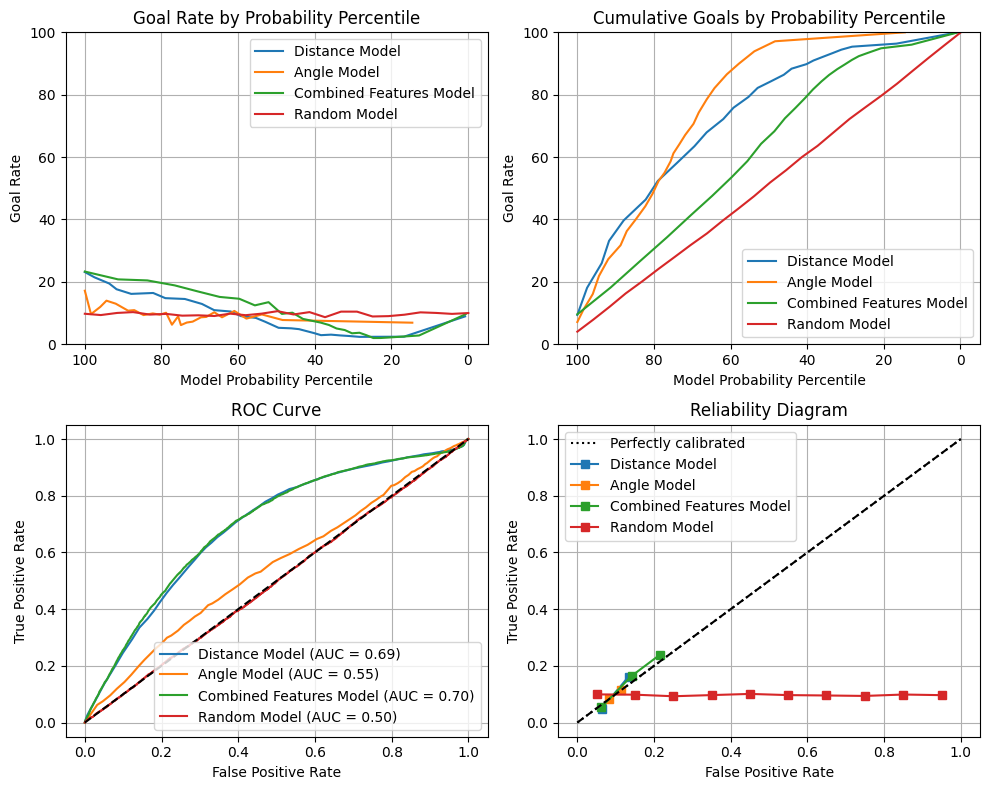

In [18]:
# Initialize subplot figure
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, features in enumerate(features_list):
    if model_names[i] == 'Random Model':
        model = RandomModel()
    else:
        model = Pipeline([
            ('scaler', MinMaxScaler()),
            ('logistic_regression', LogisticRegression())
        ])
        
    # Fit the model
    model.fit(train_base[features], train_base['is_goal'])

    # Predict probabilities
    y_true = val_base[target].values.ravel()
    val_base['prob'] = model.predict_proba(val_base[features])[:, 1]

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, val_base['prob'])
    roc_auc = roc_auc_score(y_true, val_base['prob'])

    # Calculate calibration curve
    prob_true, prob_pred = calibration_curve(y_true, val_base['prob'], n_bins=10)

    # Calculate goal rate and cumulative goals
    goal_rate = val_base.groupby(pd.qcut(val_base['prob'], 25))[target].mean() * 100

    # convert interval index to its midpoint values
    # goal_rate.index = goal_rate.index.map(lambda x: x.mid)
    goal_rate.index = goal_rate.index.map(lambda x: x.left)
    goal_rate.index = np.array(goal_rate.index) / goal_rate.index.max() * 100
    
    # get the cumulative sum of goals
    # cumulative_goals = val.groupby(pd.qcut(val['prob'], 10))[target].sum().cumsum()
    cumulative_goals = goal_rate[::-1].cumsum()/goal_rate[::-1].cumsum().max() * 100

    # Log metrics to Comet
    accuracy = accuracy_score(y_true, model.predict(val_base[features]))
    f1 = f1_score(y_true, model.predict(val_base[features]), average='macro')
    recall = recall_score(y_true, model.predict(val_base[features]), average='macro')

    line_style = '-'  # Replace with the line style you want to use
    marker = None  # Replace with the marker you want to use

    # Plot goal rate
    axs[0, 0].plot(goal_rate.index, goal_rate.values, label=f'{model_names[i]}', linestyle = line_style, marker = marker)
    axs[0,0].grid(True)

    axs[0, 1].plot(cumulative_goals.index, cumulative_goals.values, label=f'{model_names[i]}', linestyle = line_style, marker = marker)
    axs[0,1].grid(True)

    axs[1, 0].plot(fpr, tpr, label=f'{model_names[i]} (AUC = {roc_auc:.2f})', linestyle = line_style, marker = marker)
    axs[1,0].grid(True)

    CalibrationDisplay.from_predictions(y_true, val_base['prob'], n_bins=10, ax=axs[1, 1], label=f'{model_names[i]}')
    axs[1, 1].grid(True)

# Finalize plots with appropriate labels, titles, and axis adjustments
for ax in axs[0, :]:  # For top row subplots
    ax.invert_xaxis()
    ax.set_xlabel('Model Probability Percentile')
    ax.set_ylabel('Goal Rate')
    ax.set_ylim([0, 100])

for ax in axs[1, :]:  # For bottom row subplots
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

# Set titles
axs[0, 0].set_title('Goal Rate by Probability Percentile')
axs[0, 1].set_title('Cumulative Goals by Probability Percentile')
axs[1, 0].set_title('ROC Curve')
axs[1, 1].set_title('Reliability Diagram')

# Add legends
for ax in axs.flatten():
    ax.legend(loc='best')

# Adjust layout, save, and close the figure
plt.tight_layout()
# plt.savefig('all_metrics_combined.png')
# plt.close()
